In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os, sys
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)
from Preprocessing.labeling import resample_close, get_t1, get_events, get_lookback_vol
from Research.fx_utils import fx_data_import, bbg_data_import, macro_data_import
from Research.FXTesting import pca_distance_loop, get_nonusd_pair_data, get_nonusd_pairs, get_nonusd_close
from Preprocessing.sampling import _get_num_concurrent_events, _get_average_uniqueness
from Preprocessing.etf_trick import ETFTrick
from Research.signals import lookback_zscore, zscore_signal, zscore_sizing, generate_pnl
from Modelling.cross_val import PurgedKFold


home_machine = True
gen_tricks = False
start_date = dt.datetime(2000,1,1)
lookback = 500
# implement citi reversion



if home_machine:
    close = fx_data_import()
    nonusd_pairs = get_nonusd_pairs(close.columns)
    pair_closes = get_nonusd_close(close, nonusd_pairs)
    tr_df = pair_closes.dropna(how='any')
else:
    close, yields = bbg_data_import(vs_dollar=True)
    nonusd_pairs = get_nonusd_pairs(close.columns)
    pair_closes, cross_yields = get_nonusd_pair_data(close, yields, nonusd_pairs)
    cross_yields = cross_yields.fillna(0)/100./365.

if not gen_tricks:
    close = close.loc[start_date:]
    pair_closes = pair_closes.loc[start_date:]

#   if we wanted to drop the union of NAs
#    cross_yields = crosses.merge(yields, left_index=True, right_index=True, suffixes=('_px','_yld'))

# generate the indicator matrix whether pair is within cluster_threshold based on pca distances
group_matrix = pca_distance_loop(close, lookback, 4, 0.1, nonusd_pairs, components_to_use=[1,2,3])

# generate x-sigma signals
zscores = lookback_zscore(pair_closes, 30, lookback)
signals = zscore_signal(zscores, 2, 'Reversion')

# only take signals where the pair is 'grouped' at the time
group_signals = signals.multiply(group_matrix.loc[signals.index[0]:])
events_d = {}
tricks = []
if not gen_tricks:
    norm_srs = pd.read_excel(r"C:\Users\Brendan\FinML\MLFin\raw_data\nocarrytrickdata.xlsx", index_col=0)
    norm_srs = norm_srs.loc[start_date:]

for pair in nonusd_pairs:
    # skip if theres no group
    if (len(group_signals[pair][abs(group_signals[pair])>0]) == 0) or pair not in norm_srs.columns:
        continue
    
    print(pair, dt.datetime.now())
    
    weights = pd.DataFrame(np.ones(pair_closes.shape[0]), index=pair_closes.index, columns=[pair])
    
    # ETF trick on one pair
    # check if we're using yields
    if gen_tricks:
        if home_machine:
            carry = pd.DataFrame(np.zeros(pair_closes.shape[0]), index=pair_closes.index, columns=[pair])
            tr = ETFTrick(pair_closes.shift(1), pair_closes, weights, carry)

        else:
            tr = ETFTrick(pair_closes.shift(1), pair_closes, weights, cross_yields)
        tr_s = tr.get_etf_series()
        tricks.append(tr_s)
    else:
        tr_s = norm_srs.loc[:,pair]
        
    events0 = zscore_sizing(group_signals[pair], pair_closes[pair], 400, 50, lookback, pt_sl=(1,4))
    if events0 is None:
        continue
    events = generate_pnl(events0, tr_s)
    events_d[pair] = events



BRLCAD 2020-02-22 20:32:14.721364
BRLMXN 2020-02-22 20:32:14.906500
BRLZAR 2020-02-22 20:32:15.305629
BRLAUD 2020-02-22 20:32:15.647223
BRLNZD 2020-02-22 20:32:15.840099
CADMXN 2020-02-22 20:32:16.035967
CADNOK 2020-02-22 20:32:16.304815
CADSEK 2020-02-22 20:32:16.470465
CADZAR 2020-02-22 20:32:16.617378
CADAUD 2020-02-22 20:32:16.761845
CADNZD 2020-02-22 20:32:16.984723
CNYSLR 2020-02-22 20:32:17.155225
DKKNOK 2020-02-22 20:32:17.375100
DKKSEK 2020-02-22 20:32:17.860622
DKKCHF 2020-02-22 20:32:18.291391
DKKEUR 2020-02-22 20:32:18.476817
DKKGBP 2020-02-22 20:32:19.220348
HKDTHB 2020-02-22 20:32:19.733658
INRKRW 2020-02-22 20:32:19.850603
INRTWD 2020-02-22 20:32:20.058508
JPYSGD 2020-02-22 20:32:20.249790
JPYGBP 2020-02-22 20:32:20.393707
KRWTWD 2020-02-22 20:32:20.689796
KRWTHB 2020-02-22 20:32:21.270490
MXNZAR 2020-02-22 20:32:21.301472
NOKSEK 2020-02-22 20:32:21.566947
NOKCHF 2020-02-22 20:32:22.195585
NOKEUR 2020-02-22 20:32:22.377426
NOKGBP 2020-02-22 20:32:22.898391
SEKCHF 2020-02

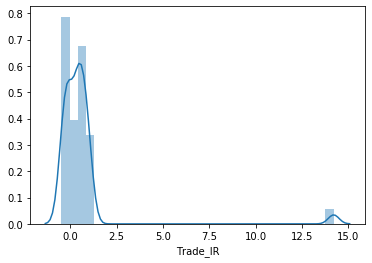

In [2]:
import seaborn as sns
cumul_pnl = pd.Series([e['ret'].sum() for key,e in events_d.items()], index=events_d.keys())
std_pnl = pd.Series([e['ret'].std() for key,e in events_d.items()], index=events_d.keys())
avg_pnl = pd.Series([e['ret'].mean() for key,e in events_d.items()], index=events_d.keys())
num_bets = pd.Series([e.shape[0] for key,e in events_d.items()], index=events_d.keys())
hit_ratio = pd.Series([e[e['ret']>0].loc[:,'ret'].count() for key,e in events_d.items()], index=events_d.keys())
pnl_df = pd.concat([cumul_pnl, std_pnl, avg_pnl, num_bets, hit_ratio/num_bets], axis=1, keys=['cumul','std','mean','num_bets','hit_ratio'])

# trade_ir not to be confused with strategy ir
# todo: method to generate daily mark to market
pnl_df['Trade_IR'] = pnl_df['mean']/pnl_df['std']
sns.distplot(pnl_df['Trade_IR'].dropna())

In [3]:
# lets put together some features
macro_data = macro_data_import().drop('PALLFNFINDEXM',axis=1)
macro_data = macro_data.rename({'Close':'VIX','PALLFNFINDEXM':'CommodIdx', 'DGS3MO': '3M_Bill','DFII10':'10Y_RY'}, axis=1)
macro_data = macro_data.replace(0, np.nan)
macro_data = macro_data.fillna(method='ffill')

# standardize
window = 125
macro_standard = macro_data.subtract(macro_data.rolling(window).mean())
macro_standard = macro_standard.divide(macro_standard.rolling(window).std())
macro_standard = macro_standard.loc[start_date:]
macro_standard.fillna(0, inplace=True)
macro_standard.tail()

,VIX,BAA10Y,3M_Bill,10Y_RY
2020-02-10,0.181924,-0.878182,-0.941054,-1.524607
2020-02-11,0.247676,-1.001162,-0.990903,-1.234641
2020-02-12,-0.357985,-0.845168,-0.849502,-1.111241
2020-02-13,-0.162662,-0.970731,-0.709327,-1.300146
2020-02-14,-0.359767,-0.954287,-0.668417,-1.347862


In [4]:
# let's train a forest on AUDNZD
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import log_loss
from Preprocessing.sampling import _get_average_uniqueness, get_sample_weight
from Modelling.feature_importance import aux_feat_imp_sfi
from Preprocessing.labeling import get_bins

pair = 'AUDNZD'

events = events_d[pair]
b = get_bins(events, norm_srs.loc[:, pair])
w = get_sample_weight(events['t1'], norm_srs.loc[:, pair])
events['bin'] = b.loc[:, 'bin']
events['w'] = w
conc = _get_num_concurrent_events(norm_srs.index, events['t1'])
avg_uniq = _get_average_uniqueness(events['t1'], conc).mean()

clf = DecisionTreeClassifier(criterion='entropy', max_features='auto', class_weight='balanced')
bc = BaggingClassifier(base_estimator=clf, n_estimators=1000, max_samples=avg_uniq, max_features=1.)

# reindex macro_standard to events starts
macro_standard = macro_standard.reindex(events.index)
imp = aux_feat_imp_sfi(macro_standard.columns, bc, macro_standard, events, 'neg_log_loss', 5)
imp
#todo
# 1. implement cross_validation scoring using PurgedKFold class
# 2. start looking at feature importance, check snippet 8.3

C:\Users\Brendan\FinML\MLFin\Preprocessing\sampling.py:196: RuntimeWarning: invalid value encountered in true_divide
  wgt = np.nansum(live_rets/num_conc_events[:, None].T, axis=1) # mx1


[-0.83963574 -0.87930298 -0.64723506 -1.22359985 -0.55818382]
[-0.60845797 -0.97843709 -0.55576263 -1.71941199 -0.59870046]
[-0.89857067 -0.80827923 -0.46488919 -1.95901659 -0.71375292]
[-0.69403363 -0.4883496  -0.45616496 -1.14048226 -0.64682584]


,mean,std
VIX,-0.829591,0.102904
BAA10Y,-0.892154,0.197135
3M_Bill,-0.968902,0.230669
10Y_RY,-0.685171,0.109552


In [5]:
#w = get_sample_weight(events['t1'], norm_srs.loc[:, pair])
from Preprocessing.sampling import get_ind_mat
close = norm_srs.loc[:, pair]
t1 = events['t1']
ret = np.array(np.log(close).diff(1).fillna(0).values) # nx1
ind_mat = get_ind_mat(close.index, t1) # n x m
num_conc_events = ind_mat.sum(axis=1) # live events per close index (nx1)
live_rets = ind_mat.transpose()*ret #live returns in rows per event (m x n)

wgt = np.nansum(live_rets/num_conc_events[:, None].T, axis=1) # mx1

#wgt[np.isnan(wgt)] = 0
wgt*= wgt.shape/np.nansum(wgt)
print(wgt)
wgt = pd.Series(abs(wgt), index=t1.index, name='w')

[ 4.17052149e+01  2.23033390e+01  1.27537480e+01  7.41698527e+00
 -1.63036431e+00 -2.44312388e+00 -4.29600852e+00 -3.23450951e+00
 -5.39813295e+00  1.00353159e+00 -1.13448995e+01 -8.90821864e+00
 -7.26894911e+00  2.47833446e-01 -2.19837712e+00  6.87992261e-01
 -2.18815102e-01 -1.11748471e+00 -3.08662042e+00  5.91949177e-01
  3.45346485e-01  2.00717574e+00  1.40045902e+00  2.08918389e+00
  5.80004503e-01  4.05802406e-01  2.30155450e+00  2.21267627e+00
  2.92482488e+00  3.14066103e+00  3.53351055e+00  3.80780050e+00
  1.64488337e+00  2.50191377e+00  3.60306624e+00  3.39145831e-01
 -6.29851125e-01 -3.06767260e+00 -4.15933648e+00 -4.27393703e+00
 -5.09735662e+00 -2.56112210e+00 -4.08659250e+00 -4.74942522e+00
 -4.87709018e+00 -4.49864467e+00 -4.25941269e+00 -4.03596977e+00
 -1.53670715e+00 -4.04738644e+00 -5.17722805e+00 -2.91816033e+00
 -2.28291580e+00 -2.63336709e+00 -4.09205569e+00 -3.78838788e+00
 -4.70057742e+01  1.16017506e+01  8.57181290e+00  1.13953317e+01
  8.96730713e+00  1.25895

C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


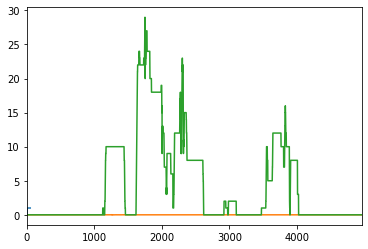

In [6]:
live_rets[1]
pd.Series(ind_mat[1150:1200,1]).plot()
ind_mat[1152:1156].sum(axis=1)
pd.Series(live_rets[1]).plot()
pd.Series(num_conc_events).plot()